# Import

In [1]:
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory

# Data importeren

Importeren van de data uit drive,
vul de authorization code in die verkregen wordt via de link of er wordt al direct een scherm opgebracht waar je kan inloggen.

In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Schilderijen-Classificeren_Arthur-Huys/datasets" "/content/datasets"

Mounted at /gdrive


In [3]:
import shutil
shutil.unpack_archive('datasets/Picasso_Rubens_VanGogh_Mondriaan_1000_50_50.zip','.','zip')

# creëren datasets

Bij het creëren van deze datasets moet de class_mode verandert naar categorical omdat we nu met multi class data werken (3 verschillende labels).

In [4]:
train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_Mondriaan_1000_50_50/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_Mondriaan_1000_50_50/validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_Mondriaan_1000_50_50/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

Found 4000 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.


# Building model

In [5]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=4,
    classifier_activation="softmax")

base_model.trainable = True
for layer in base_model.layers[:-12]:
  layer.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [6]:
data_augmentation = keras.Sequential(
    [layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
     layers.RandomContrast(0.5,1.5)])

In [7]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [8]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

# Training model

In [9]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [10]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 0.5449 - accuracy: 0.8572

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


125/125 [==============================] - 56s 323ms/step - loss: 0.5449 - accuracy: 0.8572 - val_loss: 0.1128 - val_accuracy: 0.9650
Epoch 2/30
125/125 [==============================] - 39s 299ms/step - loss: 0.1629 - accuracy: 0.9460 - val_loss: 0.1039 - val_accuracy: 0.9700
Epoch 3/30
125/125 [==============================] - 39s 299ms/step - loss: 0.1071 - accuracy: 0.9603 - val_loss: 0.1001 - val_accuracy: 0.9550
Epoch 4/30
125/125 [==============================] - 39s 298ms/step - loss: 0.0776 - accuracy: 0.9737 - val_loss: 0.0960 - val_accuracy: 0.9800
Epoch 5/30
125/125 [==============================] - 39s 298ms/step - loss: 0.0737 - accuracy: 0.9762 - val_loss: 0.0950 - val_accuracy: 0.9700
Epoch 6/30
125/125 [==============================] - 38s 293ms/step - loss: 0.0563 - accuracy: 0.9803 - val_loss: 0.0954 - val_accuracy: 0.9550
Epoch 7/30
125/125 [==============================] - 38s 293ms/step - loss: 0.0483 - accuracy: 0.9830 - val_loss: 0.1195 - val_accuracy: 0.9

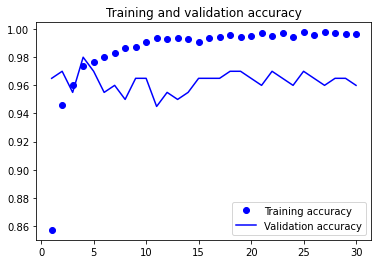

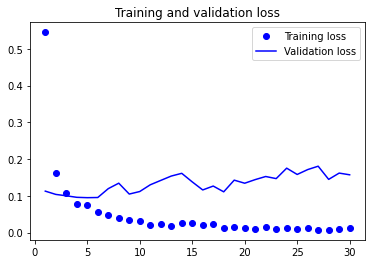

In [11]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Testing

Hier kunnen we weer zien dat de validation accuracy ongeveer gelijk blijf na de 40ste epoch.

In [12]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

7/7 [==============================] - 3s 192ms/step - loss: 0.1330 - accuracy: 0.9500
Test accuracy: 0.950


In [13]:
test_model.save("model_four_painters.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


We zien dat dit model een accuracy behaald van 95% op de test data.

In [14]:
!ln -s "/gdrive/My Drive/Schilderijen-Classificeren_Arthur-Huys/models" "/content/models"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
